# BigEarthNet Analysis - UMAP Tests

In [1]:
import torch
import matplotlib.pyplot as plt
import umap
import umap.plot
from convert_labels import convert_labels
import numpy as np

/Users/mattifrind/Documents/Programming/DOFA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mattifrind/Documents/Programming/DOFA/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
out_logits = torch.load('./features/logits-train-bigearthnet.pth')
out_feat = torch.load('./features/feat-train-bigearthnet.pth')
save_labels = torch.load('./features/labels-train-bigearthnet.pth')

In [3]:
flattened_features = np.array(out_feat.view(-1, 768))
flattened_labels = np.array(save_labels.view(-1, 43))
flattened_labels = convert_labels(flattened_labels)

In [4]:
train_count = 10000

In [6]:
mapper = umap.UMAP().fit(flattened_features[:train_count])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
def computeOneVSRestLabel(cls_index, labels):
    # tensor with 1 if the label vector has a one at cls_index, 0 otherwise
    one_vs_rest = torch.zeros(labels.shape[0])
    for i in range(labels.shape[0]):
        if labels[i][cls_index] == 1:
            one_vs_rest[i] = 1
    return one_vs_rest

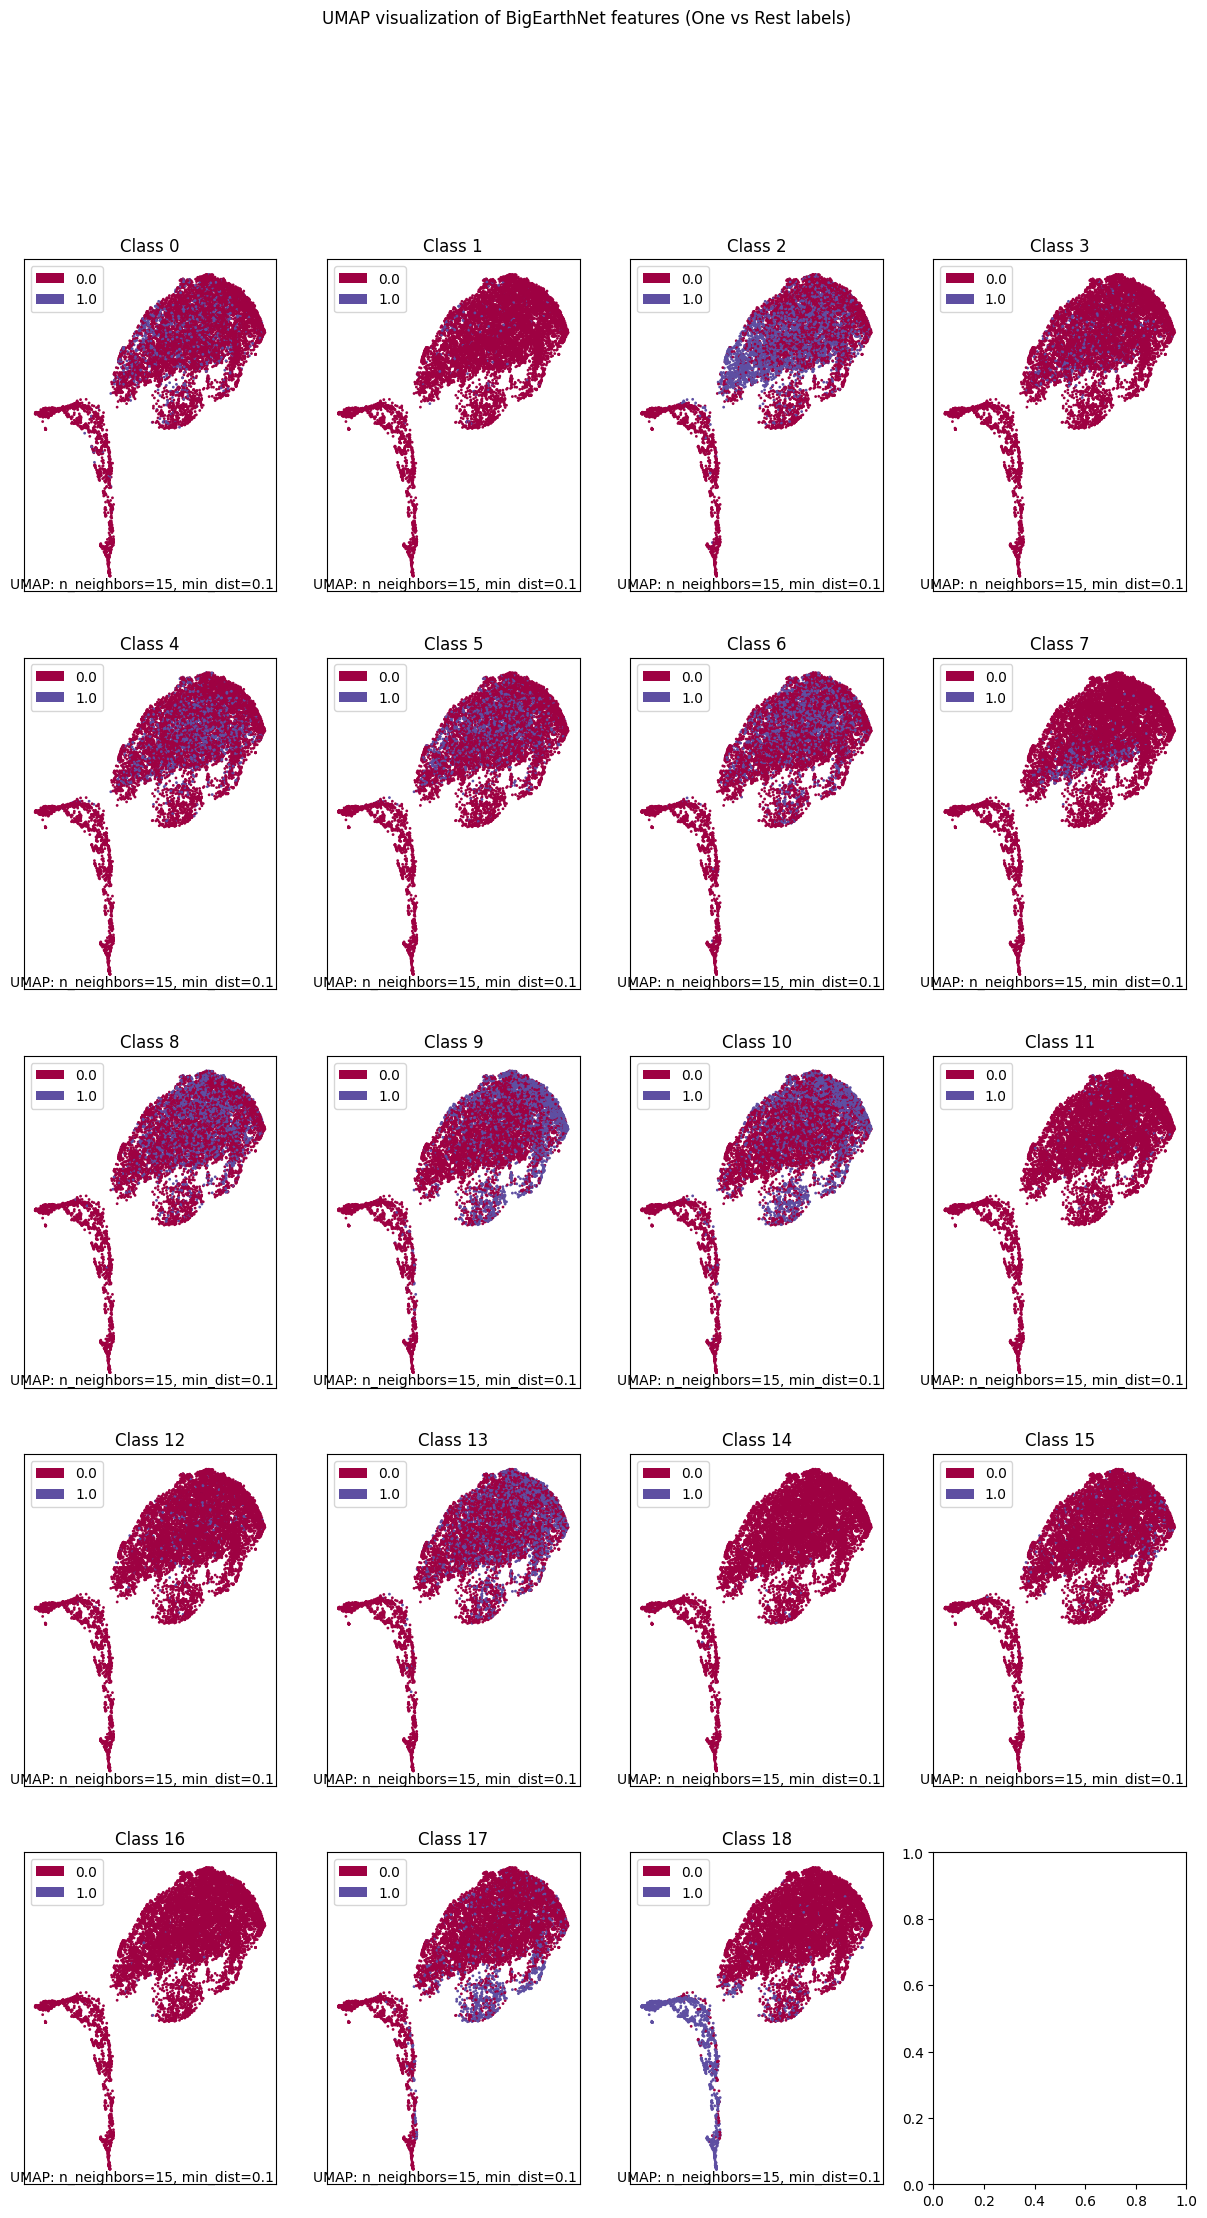

In [14]:
# 5 x 4 grid
fig, axs = plt.subplots(5, 4, figsize=(15, 25))
fig.suptitle('UMAP visualization of BigEarthNet features (One vs Rest labels)')
for i in range(19):
    one_vs_rest = computeOneVSRestLabel(i, flattened_labels[:train_count])
    umap.plot.points(mapper, labels=one_vs_rest, ax=axs[i // 4, i % 4])
    axs[i // 4, i % 4].set_title(f'Class {i}')
plt.show()